In [1]:
import keras
import tensorflow as tf
import pickle
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import numpy as np
from keras import backend as K
import shap
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
keras.__version__

'2.6.0'

In [3]:
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                        inter_op_parallelism_threads=16, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0}
                       )

session = tf.Session(config=config)
K.set_session(session)

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [460]:
context_window = 20
np.random.seed(10)
def read_fasta_label(is_independent):
    if is_independent:
        with open('Independent data/Data/train_'+str(context_window),'rb') as train:
            train_fasta = pickle.load(train)
            train_label = pickle.load(train)
            index = [i for i in range(len(train_label))]
            np.random.shuffle(index)
#             import pickle
            with open('index','wb') as f:
                pickle.dump(index,f)
            train_fasta = np.array(train_fasta)[index]
            train_label = np.array(train_label)[index]
            val_fasta = train_fasta[-3000:]
            val_label = train_label[-3000:]
            train_fasta = train_fasta[:-3000]
            train_label = train_label[:-3000]

        with open('Independent data/Data/val_'+str(context_window),'rb') as val:
            test_fasta = pickle.load(val)
            test_label = pickle.load(val)
#         print(type(train_fasta), type(val_fasta), type(test_fasta))
        return train_fasta, train_label, val_fasta, val_label, np.array(test_fasta), np.array(test_label)
    else:
        with open('Data/train_'+str(context_window),'rb') as train:
            train_fasta = pickle.load(train)
            train_label = pickle.load(train)

        with open('Data/val_'+str(context_window),'rb') as val:
            val_fasta = pickle.load(val)
            val_label = pickle.load(val)
            
        with open('Data/test_'+str(context_window),'rb') as test:
            test_fasta = pickle.load(test)
            test_label = pickle.load(test)
        train_label = np.array(train_label)
        val_label = np.array(val_label)
        test_label = np.array(test_label)
        return train_fasta, train_label, val_fasta, val_label, test_fasta, test_label

In [461]:
train_fasta, train_label, val_fasta, val_label, test_fasta, test_label = read_fasta_label(False)

In [462]:
char_to_int = {}
char_to_int['A'] = 0
char_to_int['R'] = 1
char_to_int['N'] = 2
char_to_int['D'] = 3
char_to_int['C'] = 4
char_to_int['Q'] = 5
char_to_int['E'] = 6
char_to_int['G'] = 7
char_to_int['H'] = 8
char_to_int['I'] = 9
char_to_int['L'] = 10
char_to_int['K'] = 11
char_to_int['M'] = 12
char_to_int['F'] = 13
char_to_int['P'] = 14
char_to_int['S'] = 15
char_to_int['T'] = 16
char_to_int['W'] = 17
char_to_int['Y'] = 18
char_to_int['V'] = 19
char_to_int['-'] = 20

In [463]:
def prep(st):
    a = []
    for i in range(len(st)):
#         if i == context_window:
#             continue
        if st[i] == '-':
            a.append(st[-(i+1)])
        else:
            a.append(st[i])
    return ''.join(a)

def string_array(st):
    st = prep(st)
    arr = []
    for i in st:
        if char_to_int[i] == 20:
            return None
        arr.append(char_to_int[i])
    return arr

def rev(st):
    rev_str = []
    for i in range(len(st)-1,-1,-1):
        rev_str.append(st[i])
    return ''.join(rev_str)
def check_overlap(st):
    length = len(st)
    for i in range(length):
        if i == (length-1)//2:
            continue
        if st[i] == 'K':
            return True
    return False
        

In [464]:
lr_train_fasta = [string_array(str) for str in train_fasta]
lr_val_fasta = [string_array(str) for str in val_fasta]
lr_test_fasta = [string_array(str) for str in test_fasta]
# lr_train_fasta = []
# lr_val_fasta = []
# lr_test_fasta = []
# train_removed_indices = []
# val_removed_indices = []
# test_removed_indices = []
# ind = -1
# for st in train_fasta:
#     ind+= 1
#     arr = string_array(st) if check_overlap(st) == False else None
#     if arr is not None:
#         lr_train_fasta.append(arr)
#     else:
#         train_removed_indices.append(ind)
        
# ind = -1
        
# for st in val_fasta:
#     ind+=1
#     arr = string_array(st)
#     if arr is not None:
#         lr_val_fasta.append(arr)
#     else:
#         val_removed_indices.append(ind)
# ind = -1        
# for st in test_fasta:
#     ind += 1
#     arr = string_array(st)
#     if arr is not None:
#         lr_test_fasta.append(arr)
#     else:
#         test_removed_indices.append(ind)

# rl_train_fasta = [string_array(rev(str)) for str in train_fasta]
# rl_val_fasta = [string_array(rev(str)) for str in val_fasta]

In [465]:
lr_train_fasta = np.array(lr_train_fasta,dtype=np.int32)
lr_val_fasta = np.array(lr_val_fasta, dtype=np.int32)
lr_test_fasta = np.array(lr_test_fasta, dtype=np.int32)

# rl_train_fasta = np.array(rl_train_fasta,dtype=np.int32)
# rl_val_fasta = np.array(rl_val_fasta, dtype=np.int32)

In [466]:
lr_train_one_hot = (np.arange(lr_train_fasta.max()+1) == lr_train_fasta[...,None]).astype(int)
lr_val_one_hot = (np.arange(lr_val_fasta.max()+1) == lr_val_fasta[...,None]).astype(int)
lr_test_one_hot = (np.arange(lr_test_fasta.max()+1) == lr_test_fasta[...,None]).astype(int)

# rl_train_one_hot = (np.arange(rl_train_fasta.max()+1) == rl_train_fasta[...,None]).astype(int)
# rl_val_one_hot = (np.arange(rl_val_fasta.max()+1) == rl_val_fasta[...,None]).astype(int)

In [359]:
import pickle
r = 18
with open('Data/train_rf','rb') as f:
    lr_train_one_hot = pickle.load(f)
    train_label = pickle.load(f)
with open('Data/val_rf', 'rb') as f:
    lr_val_one_hot = pickle.load(f)
    val_label = pickle.load(f)

In [56]:
np.random.seed(0)
p = np.random.permutation(lr_train_fasta.shape[0])
q = np.random.permutation(lr_val_fasta.shape[0])

lr_train_fasta = lr_train_fasta[p]
lr_val_fasta = lr_val_fasta[q]
lr_train_one_hot = lr_train_one_hot[p]
lr_val_one_hot = lr_val_one_hot[q]

rl_train_fasta = rl_train_fasta[p]
rl_val_fasta = rl_val_fasta[q]
rl_train_one_hot = rl_train_one_hot[p]
rl_val_one_hot = rl_val_one_hot[q]

train_label = train_label[p]
val_label = val_label[q]

In [497]:
#Only DL Models
import sys
sys.path.insert(1, '/home/user/Desktop/shehab/NLP/museum/succinylation')
from keras_model import ConvolutionLayer
input_l = tf.keras.Input(shape=(2*context_window+1,20))
# model = Sequential()
# model.add(keras.layers.Embedding(20,16,input_length=2*context_window+1))
# conv_1d = keras.layers.Conv1D(filters=8, kernel_size=5, data_format='channels_last'
#                               ,input_shape=(2*context_window+1,20)
#                               , use_bias = True)(input_l)
# model.add(ConvolutionLayer(filters=8, kernel_size=5, strides = 1, data_format='channels_last', 
#                               use_bias = False, input_shape=(33,21)))
# bilstm =keras.layers.Bidirectional(LSTM(20))(conv_1d)
bilstm = keras.layers.Bidirectional(LSTM(20, return_sequences = True),
                                     input_shape=(2*context_window+1, 20),
                                     name = "Bi-LSTM")(input_l)
cnv1d = keras.layers.Conv1D(filters=8, kernel_size=5, data_format='channels_last', 
                              use_bias = True, name = "1D-CNN")(bilstm)
# model.add(LSTM(20, input_shape=(2*context_window+1, 16)))
# model.add(AttentionWithContext())
flatten = keras.layers.Flatten()(cnv1d)
output = keras.layers.Dense(1,activation='sigmoid')(flatten)
model = keras.Model(input_l, output)

In [607]:
input_lr = keras.Input(shape=(2*context_window+1,20),name='lr')
input_rl = keras.Input(shape=(2*context_window+1,20),name='rl')

conv_lr = keras.layers.Conv1D(filters=8, kernel_size=5, data_format='channels_last', 
                              input_shape=(33,20), use_bias = True)(input_lr)
conv_rl = keras.layers.Conv1D(filters=8, kernel_size=5, data_format='channels_last', 
                              input_shape=(33,20), use_bias = True)(input_rl)

lstm_lr = keras.layers.Bidirectional(LSTM(20), input_shape=(2*context_window+1, 16))(conv_lr)
lstm_rl = keras.layers.Bidirectional(LSTM(20), input_shape=(2*context_window+1, 16))(conv_rl)

concat = keras.layers.concatenate([lstm_lr,lstm_rl],axis=1)
dense = keras.layers.Dense(16, activation='relu')(concat)
output = keras.layers.Dense(1,activation='sigmoid')(dense)

model = keras.Model([input_lr,input_rl],output)

In [499]:
input_lr = tf.keras.Input(shape=(2*context_window+1,20),name='lr')
input_rl = tf.keras.Input(shape=(2*context_window+1,20),name='rl')

conv_lr = keras.layers.Conv1D(filters=8, kernel_size=5, data_format='channels_last', 
                              input_shape=(33,20), use_bias = True)(input_lr)
lstm_lr = keras.layers.Bidirectional(LSTM(20), input_shape=(2*context_window+1, 16))(conv_lr)

lstm_rl = keras.layers.Bidirectional(LSTM(20, return_sequences = True)
                                     , input_shape=(2*context_window+1, 20))(input_rl)
conv_rl = keras.layers.Conv1D(filters=8, kernel_size=5, data_format='channels_last', 
                              use_bias = True)(lstm_rl)
flat = keras.layers.Flatten()(conv_rl)

concat = keras.layers.concatenate([lstm_lr,flat],axis=1)
dense = keras.layers.Dense(16, activation='relu')(concat)
output = keras.layers.Dense(1,activation='sigmoid')(dense)

model = keras.Model([input_lr,input_rl],output)

In [254]:
#Testing with attention
inputs = keras.layers.Input(shape=(2*context_window+1,))
embedding = keras.layers.Embedding(21, 16)(inputs)
lstm = keras.layers.Bidirectional(LSTM(20, return_sequences=True))(embedding)
#dense = TimeDistributed(Dense(20))(lstm)
attentio = AttentionWithContext()(lstm)
outputs = Dense(1, activation='sigmoid')(attentio)
model = keras.Model(inputs=inputs,outputs=outputs)

In [500]:
model.summary()

Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rl (InputLayer)                 [(None, 41, 20)]     0                                            
__________________________________________________________________________________________________
lr (InputLayer)                 [(None, 41, 20)]     0                                            
__________________________________________________________________________________________________
bidirectional_72 (Bidirectional (None, 41, 40)       6560        rl[0][0]                         
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 37, 8)        808         lr[0][0]                         
___________________________________________________________________________________________

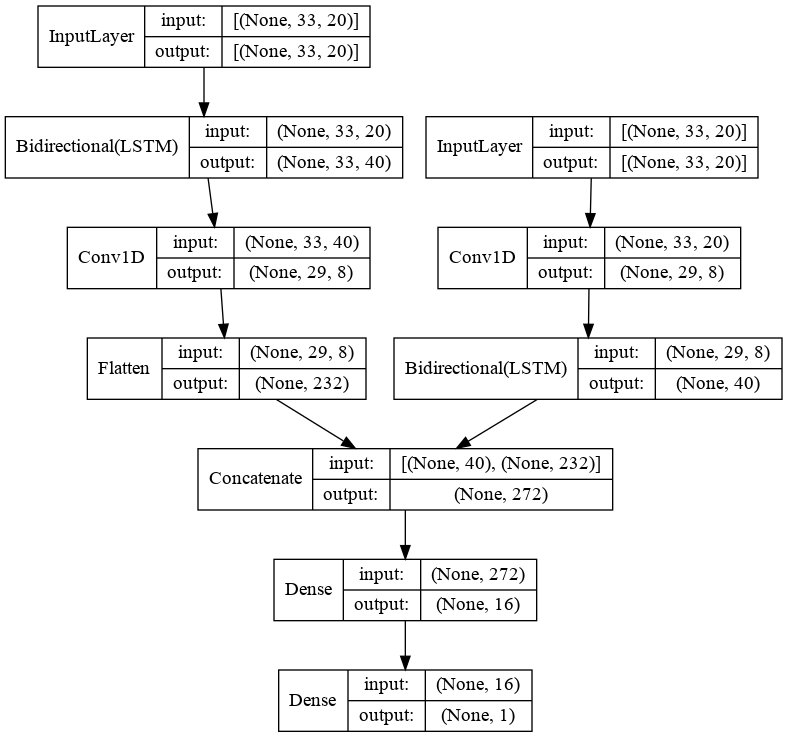

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file="CBL_BLC.png",
    show_shapes=True,
#     show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
)

In [487]:
#Only DL Models
import sys
sys.path.insert(1, '/home/user/Desktop/shehab/NLP/museum/succinylation')
from keras_model import ConvolutionLayer
input_l = tf.keras.Input(shape=(2*context_window+1,20))
# model = Sequential()
# model.add(keras.layers.Embedding(20,16,input_length=2*context_window+1))
conv_1d = keras.layers.Conv1D(filters=8, kernel_size=5, data_format='channels_last'
                              ,input_shape=(2*context_window+1,20)
                              , use_bias = True)(input_l)
# model.add(ConvolutionLayer(filters=8, kernel_size=5, strides = 1, data_format='channels_last', 
#                               use_bias = False, input_shape=(33,21)))
bilstm =keras.layers.Bidirectional(LSTM(20))(conv_1d)
# model.add(keras.layers.Bidirectional(LSTM(20, return_sequences = True), input_shape=(2*context_window+1, 20, name = "LSTM"), name = "Bi-LSTM"))
# model.add(keras.layers.Conv1D(filters=8, kernel_size=5, data_format='channels_last', 
#                               use_bias = True, name = "1D-CNN"))
# model.add(LSTM(20, input_shape=(2*context_window+1, 16)))
# model.add(AttentionWithContext())
# model.add(keras.layers.Flatten())
output = keras.layers.Dense(1,activation='sigmoid')(bilstm)
model = keras.Model(input_l, output)

In [488]:
# import tensorflow_addons as tfa

# optimizers = [
#     tf.keras.optimizers.Adam(learning_rate=5e-1),
#     tf.keras.optimizers.Adam(learning_rate=1e-3)
# ]

# optimizers_and_layers = [(optimizers[0], model.layers[0]), (optimizers[1], model.layers[1:])]
# optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam()
              , metrics=['accuracy', keras.metrics.TruePositives(), keras.metrics.TrueNegatives(),
                        keras.metrics.FalsePositives(), keras.metrics.FalseNegatives(),
                        keras.metrics.AUC()])
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [489]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler, LambdaCallback

# filepath="{epoch:02d}-{val_accuracy:.2f}.hdf5"
filepath="{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

lr_schedule = LearningRateScheduler(
    lambda epoch: learning_rate * 10** (epoch / 20)
)

In [490]:
# train_label = np.delete(train_label,train_removed_indices)
train_label.shape
# val_label = np.delete(val_label,val_removed_indices)
# test_label = np.delete(test_label,test_removed_indices)

(11642,)

In [491]:
history = model.fit(lr_train_one_hot, train_label,
          batch_size=128, epochs=80,validation_data=(lr_val_one_hot,val_label), callbacks=[checkpoint]
                    , verbose = 0, class_weight = {0:1,1:1})
# history = model.fit([lr_train_one_hot,lr_train_one_hot], train_label,
#           batch_size=128, epochs=80,validation_data=([lr_val_one_hot,lr_val_one_hot],val_label)
#                     , callbacks=[checkpoint], verbose = 0, 
#                     class_weight={0:1,1:1})
# history = model.fit(lr_train_fasta, np.array(train_label),batch_size=128, 
#           epochs=80,validation_data=(lr_val_fasta,val_label), callbacks=[checkpoint],verbose=0)


Epoch 00001: val_loss improved from inf to 0.67971, saving model to 0.68.hdf5

Epoch 00002: val_loss improved from 0.67971 to 0.67921, saving model to 0.68.hdf5

Epoch 00003: val_loss did not improve from 0.67921

Epoch 00004: val_loss improved from 0.67921 to 0.67023, saving model to 0.67.hdf5

Epoch 00005: val_loss improved from 0.67023 to 0.64522, saving model to 0.65.hdf5

Epoch 00006: val_loss improved from 0.64522 to 0.61268, saving model to 0.61.hdf5

Epoch 00007: val_loss improved from 0.61268 to 0.60530, saving model to 0.61.hdf5

Epoch 00008: val_loss improved from 0.60530 to 0.60030, saving model to 0.60.hdf5

Epoch 00009: val_loss improved from 0.60030 to 0.59999, saving model to 0.60.hdf5

Epoch 00010: val_loss did not improve from 0.59999

Epoch 00011: val_loss improved from 0.59999 to 0.59299, saving model to 0.59.hdf5

Epoch 00012: val_loss did not improve from 0.59299

Epoch 00013: val_loss did not improve from 0.59299

Epoch 00014: val_loss improved from 0.59299 to 0

In [ ]:
import matplotlib.pyplot as plt

lrs = learning_rate * 10**(np.arange(100)/20)

plt.semilogx(lrs,history.history["loss"])
plt.semilogx(lrs,history.history["val_loss"])
plt.axis([1e-6,1e-6 * 10 ** 5,0,1])

plt.show()

In [350]:
model.load_weights('cl5_loss.hdf5')

In [231]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('bidirectional_28').output)
# intermediate_layer_output = intermediate_layer_model.predict(lr_train_one_hot)
intermediate_layer_output = intermediate_layer_model.predict(lr_val_one_hot)
# intermediate_layer_output = intermediate_layer_model.predict([train_fasta,train_rf])
# intermediate_layer_output = intermediate_layer_model.predict([val_fasta,val_rf])

print((intermediate_layer_output.shape))
# np.savetxt('dl_output_train.txt',intermediate_layer_output)
np.savetxt('dl_output_val.txt',intermediate_layer_output)

(1382, 40)


In [351]:
# score = model.evaluate(lr_test_fasta, test_label, verbose=0)
# score = model.evaluate([lr_val_one_hot, lr_val_one_hot], val_label, verbose=0)
score = model.evaluate(lr_val_one_hot, val_label, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

tp = score[2]
tn = score[3]
fp = score[4]
fn = score[5]

sn = tp / (tp + fn)
sp = tn / (fp + tn)
acc = (tp + tn) / (tp + tn + fp + fn)
mcc = (tp * tn - fp * fn) / (np.sqrt((tp+fn)*(tp+fp)*(tn+fn)*(tn+fp)))

print(sn, sp, acc, mcc, score[6])

Test loss: 0.5925438188436924
Test accuracy: 0.68017364
0.75574714 0.6034985 0.68017364 0.3636222 0.74433666


In [31]:
print(len(train_fasta[10]))

33


In [800]:
# predictions = model.predict(lr_val_one_hot)
# predictions = model.predict(lr_test_one_hot)
predictions = model.predict([lr_val_one_hot,lr_val_one_hot])
predictions = predictions.reshape((predictions.shape[0],1))
prev = np.loadtxt('ensemble_ind_val_loss.txt')
prev = prev.reshape((prev.shape[0],-1))
if prev.shape[0] != 0:
    prev = np.concatenate((prev,predictions),axis = 1)
else:
    prev = predictions
np.savetxt('ensemble_ind_val_loss.txt',prev)

In [19]:
background = lr_train_one_hot[np.random.choice(lr_train_one_hot.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(lr_val_one_hot)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [20]:
import pickle
with open('CBL_50_1000_shaps', 'wb') as f:
    pickle.dump(shap_values[0],f)

20


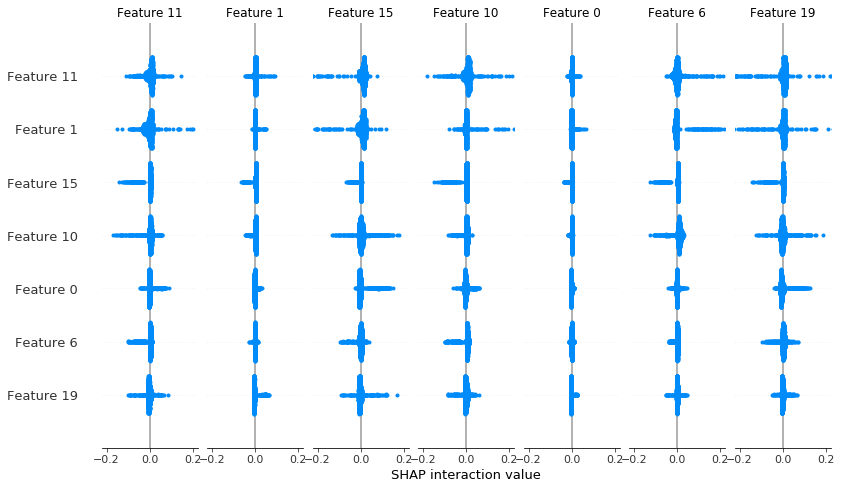

In [32]:
# import pandas as pd
# df = pd.DataFrame(lr_val_one_hot, columns = [i for i in range(1,lr_val_one_hot.shape[1]+1)])
print(len(shap_values[0][0][0]))
shap.summary_plot(shap_values[0], plot_type='bar')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0])

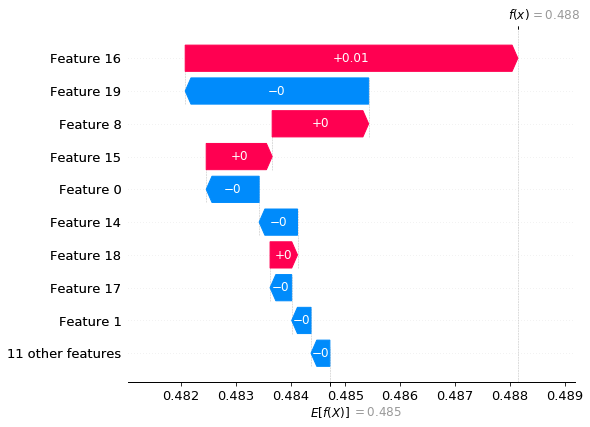

In [62]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0][1])

In [28]:
import matplotlib
matplotlib.__version__

'3.1.1'